In [1]:
using StatsBase
using GLM
using DataFrames
using Gadfly
using Cairo
using Fontconfig
using Formatting
using Compose, Colors

INFO: Recompiling stale cache file /home/kilian/.julia/lib/v0.6/StatsBase.ji for module StatsBase.
INFO: Precompiling module GLM.
INFO: Precompiling module DataFrames.
INFO: Precompiling module Gadfly.
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:339
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:339
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:339
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:365
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:365
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:365
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:365
  likely near /home/kilian/.julia/v0.6/Compose/src/property.jl:365
  likely near /home/kilian/.julia/v0.6/Compose/src/svg.jl:141
  likely near /home/kilian/.julia/v0.6/Compose/src/svg.jl:141
  likely near /home/kilian/.julia/v0.6/Compose/src/svg.jl:141
  likely near /home/kilian/.julia/v0.6/Compose/src/svg.jl:141
INFO: Precompi

In [2]:
# get the data into a DataFrame

fulldf = DataFrame()

probnames = [:foo, :galid, :groupid, :cenid, :rband, :Psat, :Mh, :foo2, :foo3, :foo4, :projR, :projrad, :angRh]
corrnames = [:foo5, :galid, :M_r, :M_g, :cz, :Dn4000, :H_delta, :logsSFR, :stelM, :ra, :dec, :vdisp, :S2N, :sersic,
             :conc, :KplusA, :R_exp, :surfdens1kpc, :surfdensR_e, :surfdensR_eo2, :vdisp_err, :Bulge2Tlr, :B2T_err,
             :GMoR_e, :R_e]

probfiles = ["dat/clf_groups_M18_M9.4.prob", "dat/clf_groups_M19_M9.8.prob", "dat/clf_groups_M20_M10.3.prob"]
corrfiles = ["dat/clf_groups_M18_M9.4.galdata_corr", "dat/clf_groups_M19_M9.8.galdata_corr", "dat/clf_groups_M20_M10.2.galdata_corr"]
densfiles = ["dat/density_r10.M18_M9.4", "dat/density_r10.M19_M9.8", "dat/density_r10.M20_M10.3"]
randfiles = ["dat/drandom_r10.M18_M9.4", "dat/drandom_r10.M19_M9.8", "dat/drandom_r10.M20_M10.3"]

for i in 1:3
    
    # read the two catalogues in and join them on galaxy id
    probdf = readtable(probfiles[i], separator=' ', header=false)
    names!(probdf, probnames)
    corrdf = readtable(corrfiles[i], separator=' ', header=false)
    names!(corrdf, corrnames)
    
    # add a column for the density, corrected with the randoms
    density = readdlm(densfiles[i])
    rands = readdlm(randfiles[i])
    ρ_corr = 1.25 * (density[:, 1] ./ rands[:, 1])
    probdf[:ρ_env] = DataArray(ρ_corr)
    
    joindf = join(probdf, corrdf, on=:galid)
   
    if i == 1
        fulldf = joindf
    else
        fulldf = [fulldf; joindf]
    end
end

fulldf = unique(fulldf, :galid)
    
# Now take all the rows out which don't have central galaxies
fulldf = fulldf[fulldf[:Psat] .< 0.5, :]

# And remove any galaxies in environment density less than or equal to zero, to avoid computational issues
fulldf = fulldf[fulldf[:ρ_env] .> 0.0, :]

# add a column for log10 of stellar mass
fulldf[:log10M] = log10.(fulldf[:stelM])

90328-element DataArrays.DataArray{Float64,1}:
 10.3666 
  9.46536
 10.5335 
 10.7409 
  9.60447
  9.68866
  9.99084
  9.5851 
  9.96369
  9.86037
 10.5326 
  9.57903
 10.3271 
  ⋮      
 10.3232 
 10.5386 
 10.3309 
 10.4875 
 10.5493 
 10.4342 
 10.3944 
 10.5359 
 10.3377 
 10.887  
 10.8045 
 10.3872 

In [5]:
# # Now to reproduce Fig 4 from Tinker's paper I
# 
# # start an array for plots
# subplots = Array{Gadfly.Plot, 1}(6)
# 
# # First make samples in stellar mass bins of 0.2 dex wide, centered on the values in the paper
# binedges = [[9.4, 9.6], [9.6, 9.8], [9.8, 10], [10, 10.2], [10.3, 10.5], [10.5, 10.7]]
# 
# for (e, edges) in enumerate(binedges)
#     mask = edges[1] .<= fulldf[:log10M] .< edges[2]
#     
#     # get 10 density bins in logspace
#     minρ = minimum(fulldf[:ρ_env][mask])
#     maxρ = maximum(fulldf[:ρ_env][mask])
#     ρedges = logspace(log10(minρ), log10(maxρ), 11)
#     ρcens = 10 .^ (0.5 * (log10.(ρedges[1:10]) + log10.(ρedges[2:11])))
#     
#     # now to find the quenched fraction in each bin
#     quenfrac = zeros(10)
#     for i in 1:10
#         binmask = ρedges[i] .<= fulldf[:ρ_env][mask] .< ρedges[i + 1]
#         quenfrac[i] = sum(fulldf[:Dn4000][mask][binmask] .> 1.6) / sum(binmask)
#     end
#     
#     bincen = 0.5 * sum(edges)
#     miny, maxy = 0.4, 1.0
#     if e in 1:3
#         miny, maxy = 0.0, 0.6
#     end
#     subplots[e] = plot(x=ρcens, y=quenfrac, Geom.line, Scale.x_log10,
#                        Coord.cartesian(xmin=log10(0.05), xmax=log10(30), ymin=miny, ymax=maxy),
#                        Guide.xlabel("ρ/ρₘ"), Guide.ylabel("f_Q"), Guide.title("log Mₛ = $bincen"))
# #                       Guide.annotation(compose(context(), text(log10(0.2), 0.5, "log Mₛ = $bincen"))))
# end
# 
# fig = vstack(hstack(subplots[1:3]), hstack(subplots[4:6]))


In [3]:
# now restrict to quenched galaxies and add a column for log of environment
quendf = fulldf[fulldf[:Dn4000] .> 1.6, :]
quendf[:logρ] = log10.(quendf[:ρ_env])

60409-element DataArrays.DataArray{Float64,1}:
  0.664692 
  0.606112 
  0.506432 
 -0.0458001
  0.688759 
  0.700712 
  0.283122 
  0.602573 
  0.66155  
  0.370755 
  0.423103 
  0.227426 
  0.12994  
  ⋮        
  0.0743728
 -0.551882 
  0.207664 
 -0.0869951
 -0.0992989
  0.46852  
  0.438871 
  0.472313 
  0.0468292
  0.0989412
  0.134669 
  0.450036 

In [ ]:
lm1 = fit(LinearModel, @formula(logρ ~ Dn4000), quendf)

In [ ]:
corr1 = cor(quendf[:Dn4000], quendf[:logρ])

In [ ]:
f(x) = lm1.model.pp.beta0[1] + lm1.model.pp.beta0[2] * x

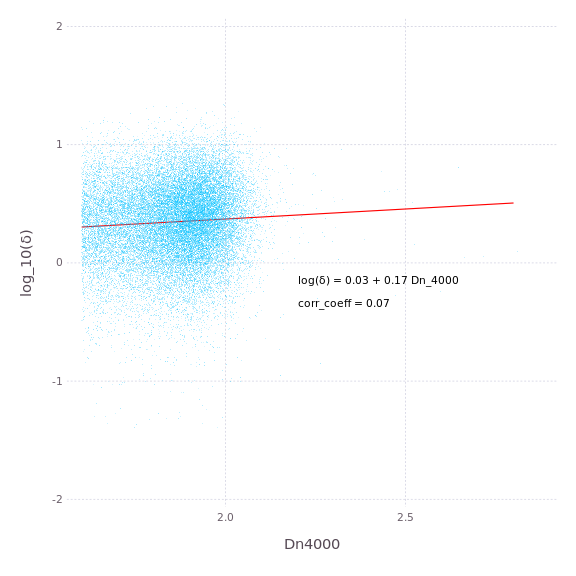

In [4]:
pt_theme = Theme(point_size=0.1mm, highlight_width=0pt)
ln_theme = Theme(default_color="red")

# p = plot(x=quendf[:Dn4000], y=log10.(quendf[:ρ_env]), Geom.point, Coord.cartesian(xmin=1.58, xmax=2.9), pt_theme,
#          Guide.xlabel("Dn4000"), Guide.ylabel("log_10(δ)"),
#          Guide.annotation(compose(context(),
#                                   Compose.text(2.2, -0.2,
#                                                Formatting.format("log(δ) = {1:.2f} + {2:.2f} Dn_4000", lm1.model.pp.beta0...)))),
#          Guide.annotation(compose(context(),
#                                   Compose.text(2.2, -0.4,
#                                                Formatting.format("corr_coeff = {1:.2f}", corr1)))))
# 
# q = layer(f, 1.6, 2.8, ln_theme)
# append!(p.layers, q)
# 
# draw(PNG("rho_v_Dn.png", 6inch, 6inch), p)
display("image/png", read("rho_v_Dn.png"))

In [ ]:
# Next we look at the relationship between evironment and R_e
lm2 = fit(LinearModel, @formula(R_e ~ logρ), quendf)

In [ ]:
corr2 = cor(quendf[:R_e], quendf[:logρ])

In [5]:
linmod(x, mod) = mod.model.pp.beta0[1] + mod.model.pp.beta0[2] * x

linmod (generic function with 1 method)

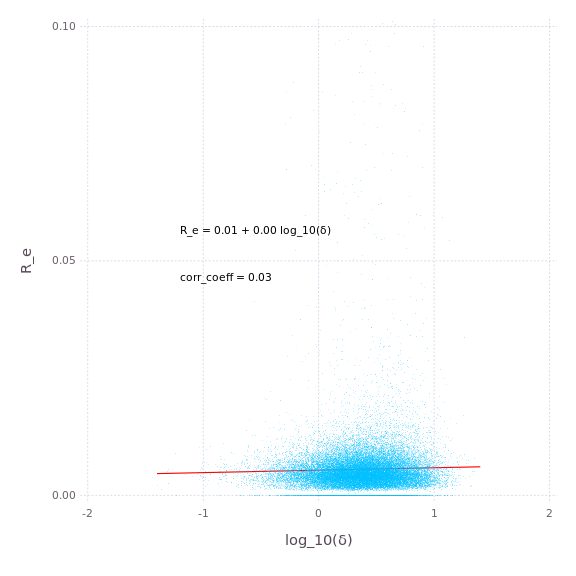

In [6]:
# p2 = plot(x=quendf[:logρ], y=quendf[:R_e], Geom.point, Coord.cartesian(ymin=0, ymax=0.1), pt_theme,
#           Guide.xlabel("log_10(δ)"), Guide.ylabel("R_e"),
#           Guide.annotation(compose(context(),
#                                    Compose.text(-1.2, 0.055,
#                                                 Formatting.format("R_e = {1:.2f} + {2:.2f} log_10(δ)", lm2.model.pp.beta0...)))),
#           Guide.annotation(compose(context(),
#                                    Compose.text(-1.2, 0.045,
#                                                 Formatting.format("corr_coeff = {1:.2f}", corr2)))))
# 
# lmod2(x) = linmod(x, lm2)
# 
# q2 = layer(lmod2, -1.4, 1.4, ln_theme)
# append!(p2.layers, q2)
# 
# draw(PNG("R_e_v_rho.png", 6inch, 6inch), p2)
display("image/png", read("R_e_v_rho.png"))

In [7]:
# now for relationship of sigma_v and logρ

lm3 = fit(LinearModel, @formula(vdisp ~ logρ), quendf)
corr3 = cor(quendf[:vdisp], quendf[:logρ])


0.03305875350073493

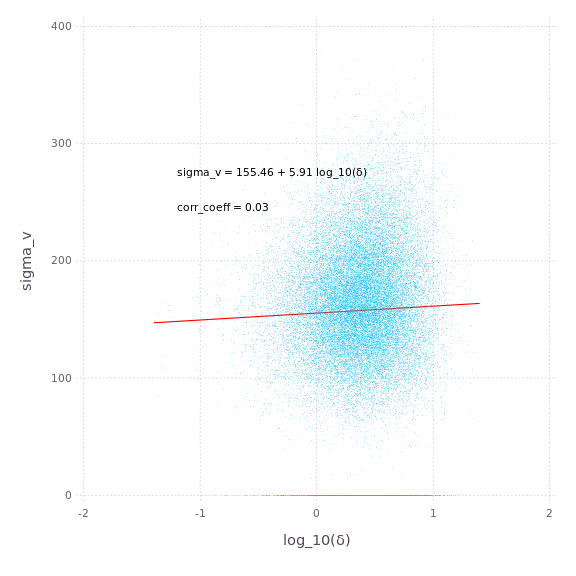

  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:1
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
  likely near In[8]:15
in render a

In [8]:
p3 = plot(x=quendf[:logρ], y=quendf[:vdisp], Geom.point, Coord.cartesian(ymin=0, ymax=400), pt_theme,
          Guide.xlabel("log_10(δ)"), Guide.ylabel("sigma_v"),
          Guide.annotation(compose(context(),
                                   Compose.text(-1.2, 270,
                                                Formatting.format("sigma_v = {1:.2f} + {2:.2f} log_10(δ)", lm3.model.pp.beta0...)))),
          Guide.annotation(compose(context(),
                                   Compose.text(-1.2, 240,
                                                Formatting.format("corr_coeff = {1:.2f}", corr3)))))

lmod3(x) = linmod(x, lm3)

q3 = layer(lmod3, -1.4, 1.4, ln_theme)
append!(p3.layers, q3)

draw(PNG("sigma_v_rho.png", 6inch, 6inch), p3)
display("image/png", read("sigma_v_rho.png"))

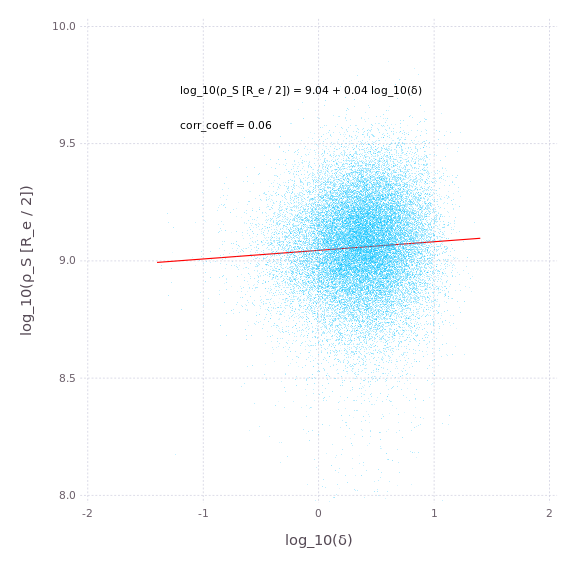

In [41]:
# now for relationship of surface density at R_e / 2 and logρ

# first get rid of a pesky NaN and some zeros while we're at it
surfdf = quendf[quendf[:surfdensR_eo2] .> 0.0, :]

# adding a log column seems to make sense
surfdf[:log_sdRe2] = log10.(surfdf[:surfdensR_eo2])

lm4 = fit(LinearModel, @formula(log_sdRe2 ~ logρ), surfdf)
corr4 = cor(surfdf[:log_sdRe2], surfdf[:logρ])
    
p4 = plot(x=surfdf[:logρ], y=surfdf[:log_sdRe2], Geom.point, Coord.cartesian(ymin=8, ymax=10), pt_theme,
          Guide.xlabel("log_10(δ)"), Guide.ylabel("log_10(ρ_S [R_e / 2])"),
          Guide.annotation(compose(context(),
                                   Compose.text(-1.2, 9.7,
                                                Formatting.format("log_10(ρ_S [R_e / 2]) = {1:.2f} + {2:.2f} log_10(δ)", lm4.model.pp.beta0...)))),
          Guide.annotation(compose(context(),
                                   Compose.text(-1.2, 9.55,
                                                Formatting.format("corr_coeff = {1:.2f}", corr4)))))

lmod4(x) = linmod(x, lm4)

q4 = layer(lmod4, -1.4, 1.4, ln_theme)
append!(p4.layers, q4)

draw(PNG("surfd_v_rho.png", 6inch, 6inch), p4)
display("image/png", read("surfd_v_rho.png"))

In [35]:
NaN > 0

false

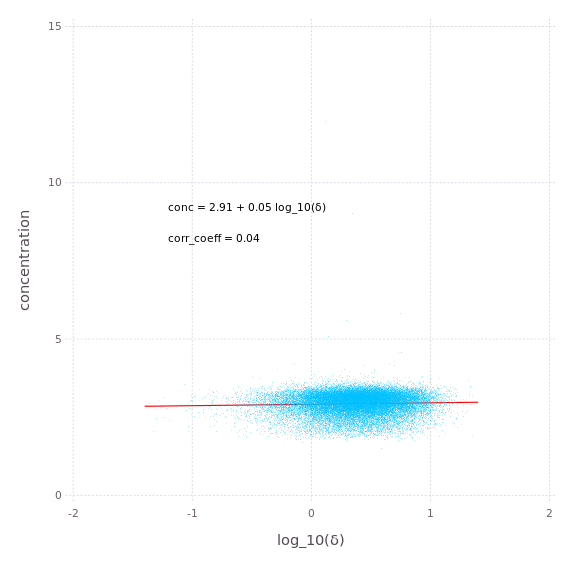

In [47]:
# now for relationship of sigma_v and logρ

lm5 = fit(LinearModel, @formula(conc ~ logρ), quendf)
corr5 = cor(quendf[:conc], quendf[:logρ])


p5 = plot(x=quendf[:logρ], y=quendf[:conc], Geom.point, pt_theme,
          Guide.xlabel("log_10(δ)"), Guide.ylabel("concentration"),
          Guide.annotation(compose(context(),
                                   Compose.text(-1.2, 9,
                                                Formatting.format("conc = {1:.2f} + {2:.2f} log_10(δ)", lm5.model.pp.beta0...)))),
          Guide.annotation(compose(context(),
                                   Compose.text(-1.2, 8,
                                                Formatting.format("corr_coeff = {1:.2f}", corr5)))))

lmod5(x) = linmod(x, lm5)

q5 = layer(lmod5, -1.4, 1.4, ln_theme)
append!(p5.layers, q5)

draw(PNG("conc_v_rho.png", 6inch, 6inch), p5)
display("image/png", read("conc_v_rho.png"))